In [1]:
!pip3 install pg8000==1.31.2 boto3==1.34.136 uuid==1.30
!pip install tabulate==0.9.0

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 1.3 MB/s eta 0:00:0000:0100:01
  Created wheel for uuid: filename=uuid-1.30-py3-none-any.whl size=6503 sha256=fe5f8da1a5ef77783e64606faa24885c5d5e3a745ba5f3016c1368a19b2da54c
  Stored in directory: /root/.cache/pip/wheels/ed/08/9e/f0a977dfe55051a07e21af89200125d65f1efa60cbac61ed88
Successfully built uuid


In [38]:
import os
import boto3
import dotenv
import random
from typing import Generator, List, Type
from unidecode import unidecode
import shutil
import pandas as pd
import matplotlib.pyplot as plt

from libs.utils.connector_llm import *
from libs.utils.logger import get_logger

dotenv.load_dotenv()
logger = get_logger('libs.evaluation')

In [4]:
class SkaylinkAgent():
    def __init__(self, modelId: str, RDS_table_name: str, RDS_database_name: str, message_history: List[dict] = []):
        '''
        @param message_history: a list of dictionaries, each dictionary is a message like ``
        '''
        pass
 
    def run(self) -> str:
        '''
        returns the final answer, whtever steps are done in the middle
        '''
        pass
 
 
    def run_stream(self) -> Generator[str, None, None]:
        '''
        Basically the same as `run`, but it returns the answer in chunks
        '''
        pass


class MockAgent(SkaylinkAgent):
    def run(self) -> str:
        return random.choice([
            "hi",
            "How are you doing",
            "sorry, I don't know how to answer that",
        ])
 

 
 
##########
# This will run in the lambda
'''
agent = MockAgent(
    modelId = 'not-needed',
    RDS_table_name = 'not-needed',
    RDS_database_name = 'not-needed',
    message_history = [{
        'role': 'user',
        'content': 'hi',
    }],
)

print(agent.run())
''';

In [92]:
def load_eval_dataset(dataset_path: str) -> pd.DataFrame:
    # TODO: consider filters ("only area=chitchat"), row limit, super_important multiplier (repeat the columns)
    eval_dataset = pd.DataFrame([
        ['what is the color of the sky', 'blue', 'chitchat', '', 'leonardo', 'easy', False, False],
        ['what is the capital of Brasil', 'Brasília', 'chitchat', '', 'leonardo', 'medium', False, True],
        ['explain like I\'m 5 how the regex of the eventype sustainability works', '...', 'event-type', '', 'leonardo', 'hard', True, True],
        ['how many fragments do we have this month', 'We have <number> fragments', 'statistics', '', 'leonardo', 'medium', False, True],
        ['how many fragments with eventtypes related to climawandern do we have this month', 'We have <number> fragments', 'statistics', '', 'leonardo', 'medium', False, True],
    ], columns=["question", "gold_answer", "area", "focused_elements", "clarification_by", "difficulty", "out_of_scope_for_now", "super_important"])
    eval_dataset = eval_dataset[~eval_dataset['out_of_scope_for_now']]
    return eval_dataset


def add_inferences(eval_dataset: pd.DataFrame, agent_class: Type[SkaylinkAgent]) -> pd.DataFrame:
    eval_dataset_with_inference = eval_dataset.copy()
    eval_dataset_with_inference['model_answer'] = ''
    for index, row in eval_dataset_with_inference.iterrows():
        agent = agent_class(
            modelId = 'not-needed',
            RDS_table_name = 'not-needed',
            RDS_database_name = 'not-needed',
            message_history = [{
                'role': 'user',
                'content': row['question'],
            }],
        )
        model_answer = agent.run()
        assert type(model_answer) == str
        assert len(model_answer) > 0
        eval_dataset_with_inference.loc[index, 'model_answer'] = model_answer
    return eval_dataset_with_inference

def add_evaluation_scores(eval_dataset_with_inference: pd.DataFrame, metric: Literal=['metric_coherence_score', 'metric_protectiveness_score', 'metric_similarity_score']) -> pd.DataFrame:
    assert "question" in eval_dataset_with_inference.columns
    #assert "gold_answer" in eval_dataset_with_inference.columns
    assert "area" in eval_dataset_with_inference.columns
    assert "focused_elements" in eval_dataset_with_inference.columns
    assert "clarification_by" in eval_dataset_with_inference.columns
    assert "difficulty" in eval_dataset_with_inference.columns
    assert "out_of_scope_for_now" in eval_dataset_with_inference.columns
    assert "super_important" in eval_dataset_with_inference.columns
    assert "model_answer" in eval_dataset_with_inference.columns

    eval_dataset_with_inference_and_scores = eval_dataset_with_inference.copy()
    eval_dataset_with_inference[metric] = ''
    for index, row in eval_dataset_with_inference_and_scores.iterrows():
        score = random.choice(['1', '2', '3', '4', '5'])
        eval_dataset_with_inference_and_scores.loc[index, metric] = score

    assert metric in eval_dataset_with_inference_and_scores.columns
    #assert "metric_coherence_score"
    #good_answer	issue	good_answer_transformed
    # bot's current answer
    return eval_dataset_with_inference_and_scores

def analyze_results(results: pd.DataFrame, metric: str, save_dir: str) -> None:
    '''
    Have the side effect of modifying the files at `save_dir`
    '''
    results = results.copy()
    analysis = {
        'metric_name': metric,
        'metric_name_pretty': metric.replace('metric_', '').replace('_', ' ').title(),
        'failures': int((results[metric].str.len() != 1).sum()),

    }
    
    # Ensure that the directory is clean
    if os.path.exists(save_dir):
        shutil.rmtree(save_dir)
    os.makedirs(save_dir)

    # Cleaning
    logger.info(f"{analysis['failures']} tests failed")
    results = results[results[metric].str.len() == 1]
    results[metric] = pd.to_numeric(results[metric], errors='coerce')
    results.dropna(subset=['area', 'difficulty', metric], inplace=True)
    
    # Total
    analysis['count_total'] = int(results.shape[0])
    analysis['mean_total'] = float(results[metric].mean())
    logger.info(f"Mean {analysis['metric_name_pretty']} among all {analysis['count_total']} questions: {analysis['mean_total']}")
    
    # Super Important
    results_si = results[results['super_important']]
    analysis['count_super_important'] = int(results_si.shape[0])
    analysis['mean_super_important'] = float(results_si[metric].mean())
    logger.info(f"Mean {analysis['metric_name_pretty']} among {analysis['count_super_important']} super-important questions: {analysis['mean_super_important']}")

    # Per area
    results['area'] = results['area'].str.strip().str.lower().apply(unidecode)
    grouped_results = results.groupby('area')[metric].agg(['mean', 'std', 'count'])
    analysis['mean_per_area'] = grouped_results.to_markdown()
    logger.info(f"Results for {analysis['metric_name_pretty']} per area:\n{analysis['mean_per_area']}")

    plt.figure(figsize=(10, 6))
    bars = plt.bar(grouped_results.index, grouped_results['mean'], yerr=grouped_results['std'], capsize=5, color='skyblue')

    for bar in bars:
        yval = bar.get_height()
        # Adding value labels above each bar
        plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.1, round(yval, 2), va='bottom')

    plt.title(f"Mean {analysis['metric_name_pretty']} per area, with std bars")
    plt.xlabel("Area")
    plt.ylabel("Mean Score")
    plt.xticks(rotation=60)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(save_dir + 'graph_per_area.png')
    plt.show()

    # Per difficulty
    results['difficulty'] = results['difficulty'].str.strip().str.lower().apply(unidecode)
    grouped_results = results.groupby('difficulty')[metric].agg(['mean', 'std', 'count'])
    analysis['mean_per_difficulty'] = grouped_results.to_markdown()
    logger.info(f"Results for {analysis['metric_name_pretty']} per difficulty:\n{analysis['mean_per_difficulty']}")

    plt.figure(figsize=(10, 6))
    bars = plt.bar(grouped_results.index, grouped_results['mean'], yerr=grouped_results['std'], capsize=5, color='skyblue')

    for bar in bars:
        yval = bar.get_height()
        # Adding value labels above each bar
        plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.1, round(yval, 2), va='bottom')

    plt.title(f"Mean {analysis['metric_name_pretty']} per difficulty, with std bars")
    plt.xlabel("Difficulty")
    plt.ylabel("Mean Score")
    plt.xticks(rotation=60)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(save_dir + 'graph_per_difficulty.png')
    plt.show()

    # Save
    with open(os.path.join(save_dir, 'analysis.json'), 'w') as f:
        f.write(json.dumps(analysis, indent=4))


dataset = 'evaluation-questions'
metrics = ['metric_similarity_score', 'metric_coherence_score']
eval_dataset = load_eval_dataset(f'./assets/eval/{dataset}.csv')
eval_dataset

,question,gold_answer,area,focused_elements,clarification_by,difficulty,out_of_scope_for_now,super_important
0,what is the color of the sky,blue,chitchat,,leonardo,easy,False,False
1,what is the capital of Brasil,Brasília,chitchat,,leonardo,medium,False,True
3,how many fragments do we have this month,We have <number> fragments,statistics,,leonardo,medium,False,True
4,how many fragments with eventtypes related to ...,We have <number> fragments,statistics,,leonardo,medium,False,True


In [93]:
eval_dataset_with_inference = add_inferences(eval_dataset, MockAgent)
eval_dataset_with_inference

,question,gold_answer,area,focused_elements,clarification_by,difficulty,out_of_scope_for_now,super_important,model_answer
0,what is the color of the sky,blue,chitchat,,leonardo,easy,False,False,"sorry, I don't know how to answer that"
1,what is the capital of Brasil,Brasília,chitchat,,leonardo,medium,False,True,hi
3,how many fragments do we have this month,We have <number> fragments,statistics,,leonardo,medium,False,True,hi
4,how many fragments with eventtypes related to ...,We have <number> fragments,statistics,,leonardo,medium,False,True,"sorry, I don't know how to answer that"


In [94]:
eval_dataset_with_inference_and_scores['metric_similarity_score'].str.len()

0    1
1    1
3    1
4    1
Name: metric_similarity_score, dtype: int64

[2024-08-21 12:34:18 +0000] libs.libs.evaluation INFO     0 tests failed
[2024-08-21 12:34:18 +0000] libs.libs.evaluation INFO     Mean Similarity Score among all 4 questions: 4.5
[2024-08-21 12:34:18 +0000] libs.libs.evaluation INFO     Mean Similarity Score among 3 super-important questions: 4.333333333333333
[2024-08-21 12:34:18 +0000] libs.libs.evaluation INFO     Results for Similarity Score per area:
| area       |   mean |   std |   count |
|:-----------|-------:|------:|--------:|
| chitchat   |      5 |     0 |       2 |
| statistics |      4 |     0 |       2 |


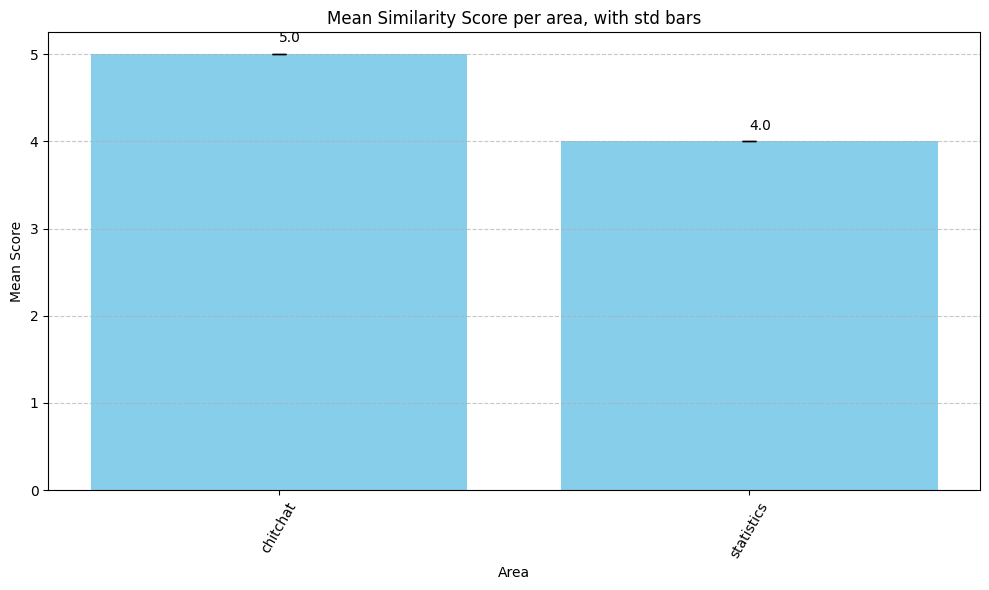

[2024-08-21 12:34:18 +0000] libs.libs.evaluation INFO     Results for Similarity Score per difficulty:
| difficulty   |    mean |       std |   count |
|:-------------|--------:|----------:|--------:|
| easy         | 5       | nan       |       1 |
| medium       | 4.33333 |   0.57735 |       3 |


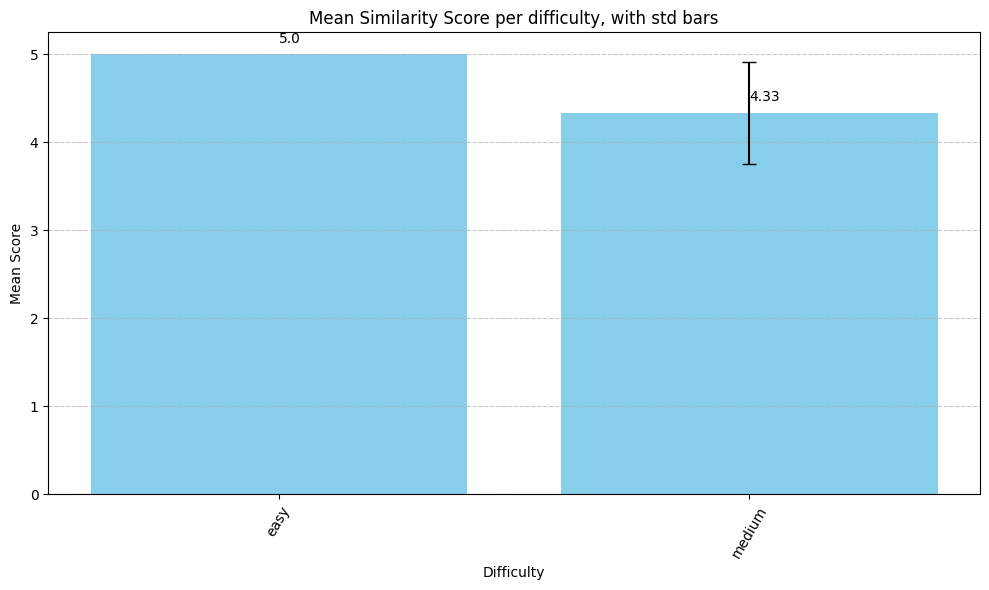

[2024-08-21 12:34:18 +0000] libs.libs.evaluation INFO     0 tests failed
[2024-08-21 12:34:18 +0000] libs.libs.evaluation INFO     Mean Coherence Score among all 4 questions: 3.0
[2024-08-21 12:34:18 +0000] libs.libs.evaluation INFO     Mean Coherence Score among 3 super-important questions: 3.3333333333333335
[2024-08-21 12:34:18 +0000] libs.libs.evaluation INFO     Results for Coherence Score per area:
| area       |   mean |      std |   count |
|:-----------|-------:|---------:|--------:|
| chitchat   |    2.5 | 0.707107 |       2 |
| statistics |    3.5 | 0.707107 |       2 |


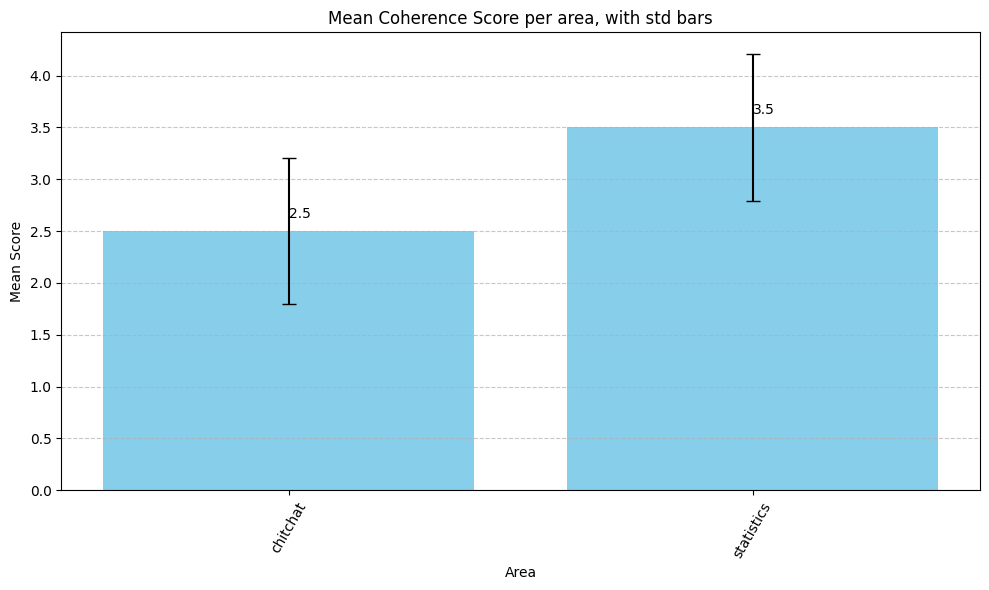

[2024-08-21 12:34:19 +0000] libs.libs.evaluation INFO     Results for Coherence Score per difficulty:
| difficulty   |    mean |       std |   count |
|:-------------|--------:|----------:|--------:|
| easy         | 2       | nan       |       1 |
| medium       | 3.33333 |   0.57735 |       3 |


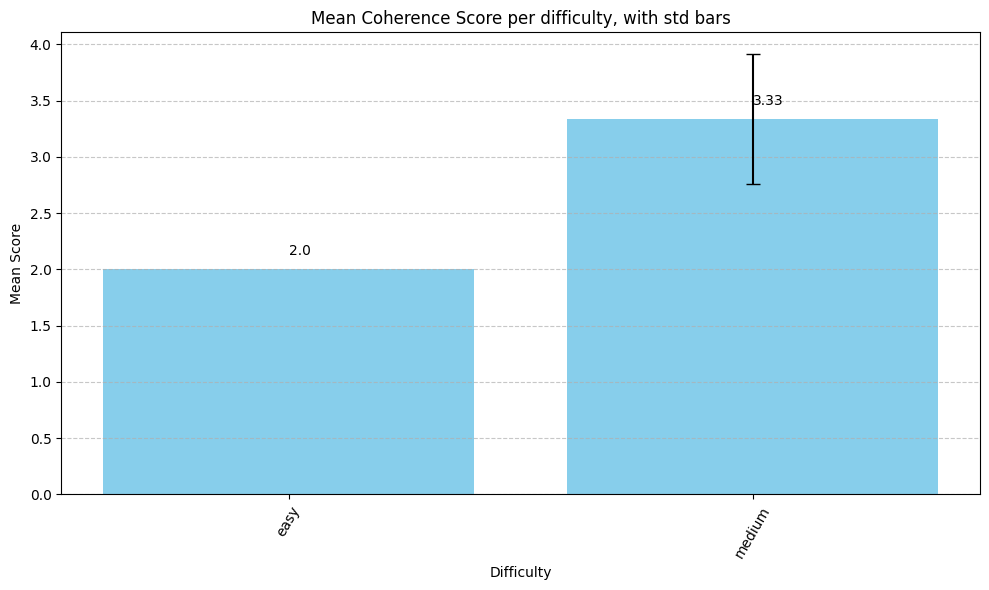

,question,gold_answer,area,focused_elements,clarification_by,difficulty,out_of_scope_for_now,super_important,model_answer,metric_similarity_score,metric_coherence_score
0,what is the color of the sky,blue,chitchat,,leonardo,easy,False,False,"sorry, I don't know how to answer that",5,2
1,what is the capital of Brasil,Brasília,chitchat,,leonardo,medium,False,True,hi,5,3
3,how many fragments do we have this month,We have <number> fragments,statistics,,leonardo,medium,False,True,hi,4,4
4,how many fragments with eventtypes related to ...,We have <number> fragments,statistics,,leonardo,medium,False,True,"sorry, I don't know how to answer that",4,3


In [95]:
eval_dataset_with_inference_and_scores = eval_dataset_with_inference.copy()
for metric in metrics:
    eval_dataset_with_inference_and_scores = add_evaluation_scores(eval_dataset_with_inference_and_scores, metric=metric)
    analyze_results(eval_dataset_with_inference_and_scores, metric=metric, save_dir=f'./assets/eval/{dataset}_{metric}/')

eval_dataset_with_inference_and_scores

In [23]:
llm = factory_create_connector_llm(
    provider='bedrock',
    modelname='anthropic.claude-3-5-sonnet-20240620-v1:0',
    credentials=CredentialsBedrock(
        aws_access_key_id=os.getenv("AWS_ACCESS_KEY_ID"),
        aws_secret_access_key=os.getenv("AWS_ACCESS_KEY_SECRET"),
    ),
)

# chat completion, normal
chat_completion = llm.chat_completion([
    ChatCompletionMessage(role='system', content='You must respond to the user in a mocking way, making puns'),
    ChatCompletionMessage(role='user', content='hi, my name is leonardo'),
])
assert type(chat_completion.choices[0].message.content) == str
assert len(chat_completion.choices[0].message.content) > 2
print(chat_completion.choices[0].message.content)

Well, well, well, if it isn't Leonardo! I hope you're not too 'shell-shocked' by my response. Are you here to 'turtle-y' dominate the conversation, or are you just feeling a bit 'green' around the gills? Don't worry, I won't 'ninja' your time - I'm just here to have some fun! So, what's on your mind, oh great Renaissance master? Painting me a picture of your day, perhaps?


In [24]:
# chat completion, stream
chat_completion_stream = llm.chat_completion_stream([
    ChatCompletionMessage(role='system', content='You must respond to the user in a mocking way, making puns'),
    ChatCompletionMessage(role='user', content='hi, my name is leonardo'),
])

answer = ''
for chunk in chat_completion_stream:
    if len(chunk.choices) > 0:
        message = chunk.choices[0].message
        if message.content:
            print(message.content, end='')
            answer += message.content
            assert type(message.content) == str
assert len(answer) > 2

Well, well, well, if it isn't Leo-nardo! I hope you're not feeling too blue about your name, though I'm sure it's been quite the masterpiece of conversation over the years. Did you bring your turtle friends along, or are you flying solo on this chat adventure? Either way, I'm sure we'll have a shell of a time!